# Building the customer and product embedding models

In [1]:
# Load and import libraries
# import matplotlib.pyplot as plt
#import numpy as np
from os import environ
import pandas as pd
# import random
# import seaborn as sns
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# import torch
# import torch.nn as nn
# import torch.optim as optim

# from torch.utils.data import DataLoader, TensorDataset
# import torch
# import torch.nn as nn
# import torch.optim as optim


from ds_abm.utils.embedding_analysis import create_double_embedding

In [2]:
# get the value of the PATH environment variable
DATAPATH = environ['DATAPATH']

In [3]:
training_data = pd.read_feather(DATAPATH+'training_data.feather')

In [4]:
# # Group data by Customer ID, InvoiceDate and compute aggregated features 
# data_grouped = training_data.groupby(['Customer ID', 'InvoiceDate']).agg({
#     'TotalSpending': 'sum',
#     'StockCode': 'nunique',
#     'Quantity': 'sum'
# }).reset_index()
# data_grouped['InvoiceDate'] = data_grouped['InvoiceDate'].dt.to_timestamp()
# data_grouped.rename(columns={'StockCode': 'NumberOfUniqueProducts'}, inplace=True)
# # Sort data by Customer ID and InvoiceDate for proper computation of next purchase date
# data_grouped_sorted = data_grouped.sort_values(['Customer ID', 'InvoiceDate'])
# # Calculate the difference in days between consecutive purchases for each customer
# data_grouped_sorted['NextPurchaseDate'] = data_grouped_sorted.groupby('Customer ID')['InvoiceDate'].shift(-1)
# data_grouped_sorted['Duration'] = (data_grouped_sorted['NextPurchaseDate'] - data_grouped_sorted['InvoiceDate']).dt.days
# # Define the 'Event' column
# data_grouped_sorted['Event'] = data_grouped_sorted['Duration'].notna().astype(int)
# # Drop the NextPurchaseDate column for cleanliness
# data_grouped_sorted.drop(columns=['NextPurchaseDate'], inplace=True)
# data_grouped_sorted.head()
# data_customer_grouped = data_grouped_sorted.groupby(['Customer ID']).agg({
#     'Duration' : 'mean', 
#     'Event': 'sum', 
#     'NumberOfUniqueProducts' : 'mean',
#     'TotalSpending' : 'mean'
# }).reset_index()

# data_customer_grouped.rename(columns={'Duration': 'avgDuration', 'Event' : 'countEvents', 'NumberOfUniqueProducts': 'avgUniqueProds', 'TotalSpending': 'avgSpending'}, inplace=True)

In [5]:
## testing functional form of code:

In [6]:
customer_embeddings, product_embeddings = create_double_embedding(df1=training_data)

In [7]:
customer_embeddings

array([[-1.3285973 , -1.2261581 ,  1.2457051 , ...,  0.03626257,
        -1.1090541 ,  0.24175858],
       [ 0.05918576, -0.73353714, -0.9060018 , ...,  1.423752  ,
         0.29867476, -0.07378581],
       [ 0.50187224, -0.50610965, -0.00451243, ...,  0.26216745,
         0.40977672, -0.9848528 ],
       ...,
       [ 0.00486996, -1.6202158 ,  0.0482025 , ...,  0.9394031 ,
        -0.7812254 ,  0.6352853 ],
       [-1.279466  , -1.3954313 ,  0.04925757, ..., -0.33096555,
        -0.13733731, -0.1112418 ],
       [-1.2956941 , -2.5157363 , -1.434625  , ..., -0.22193985,
        -1.0265973 ,  0.08873083]], dtype=float32)

In [13]:
product_embeddings.shape

(4364, 20)

In [142]:
# # we do this step to create samples of negative observations that we can use to train the embeddings model with
# # in essence we are creating combinations of customer and product that don't exist so that we can
# # use those observations together with the real data for training the classifier.
# def enrichWithFalseObservations(df1, customerCol, productCol):

#     customer_product_index = df1[[customerCol,productCol]].copy()
#     uniqueCustomers = list(customer_product_index[customerCol].drop_duplicates())
#     uniqueProducts = list(customer_product_index[productCol].drop_duplicates())
    
#     #print(len(uniqueProducts))
#     randomCustomers = random.choices(uniqueCustomers,k=len(df1)*2)
#     randomProducts= random.choices(uniqueProducts,k=len(df1)*2)
    
#     # create dataframe of random selection of customers and products
#     randomCustomerProducts = pd.DataFrame()
    
#     randomCustomerProducts['randCust'] = randomCustomers
#     randomCustomerProducts['randProd'] = randomProducts
#     randomCustomerProducts = randomCustomerProducts.drop_duplicates().reset_index(drop=True)
#     # merge random data with actual data
#     both = randomCustomerProducts.merge(customer_product_index.drop_duplicates().reset_index(drop=True), left_on=['randCust','randProd'], right_on=[customerCol,productCol])
    
#     randomCustomerProducts = randomCustomerProducts.merge(both, how='left')
#     randomCustomerProducts = randomCustomerProducts[randomCustomerProducts[customerCol].isnull()==True].drop(columns=[customerCol,productCol],axis=1)
#     randomCustomerProducts.reset_index(drop=True, inplace=True)
#     randomCustomerProducts = randomCustomerProducts.sample(len(df1))
#     randomCustomerProducts.columns = [customerCol,productCol]
    
#     randomCustomerProducts['true_shop'] = 0
#     customer_product_index['true_shop'] = 1
    
#     # puttting the data together to create the final training data sample.
#     df2 = pd.concat([randomCustomerProducts,customer_product_index])
#     df2.reset_index(drop=True, inplace=True)
#     df2['randomSortingNumbers'] = np.random.uniform(size=len(df2))
#     df2.sort_values(['randomSortingNumbers'], inplace=True)
#     df2.reset_index(drop=True, inplace=True)
#     df2.drop(columns=['randomSortingNumbers'], inplace=True)
#     del customer_product_index, uniqueCustomers, uniqueProducts, randomCustomers, randomProducts, randomCustomerProducts, both

#     return df2



In [81]:
new_training_data = enrich_with_false_observations(df1=training_data, customerCol='CustomerIndex', productCol='ProductIndex')

In [53]:
new_training_data.to_csv(dataPath+'new_training_data_torch_prep.csv')

In [ ]:
## Building Embeddings for Customer and Product

In [57]:
# Initial variables that are the same for both models

# Number of latent factors
n_factors = 20

# Number of unique customers and products
n_customers = len(customer_to_index)
n_products = len(product_to_index)

In [54]:
# Extracting relevant columns for the first pretraining embedding model
customer_indices_1 = torch.tensor(new_training_data['CustomerIndex'].values, dtype=torch.long)
product_indices_1 = torch.tensor(new_training_data['ProductIndex'].values, dtype=torch.long)
true_shop = torch.tensor(new_training_data['true_shop'].values, dtype=torch.float32)

# extracting the relevant columns for the second embedding model
customer_indices_2 = torch.tensor(training_data['CustomerIndex'].values, dtype=torch.long)
product_indices_2 = torch.tensor(training_data['ProductIndex'].values, dtype=torch.long)
quantities = torch.tensor(training_data['Quantity'].values, dtype=torch.float32)

# Checking the shapes of the tensors
customer_indices_1.shape, product_indices_1.shape, true_shop.shape, customer_indices_2.shape, product_indices_2.shape, quantities.shape, 


(torch.Size([1201978]),
 torch.Size([1201978]),
 torch.Size([1201978]),
 torch.Size([600989]),
 torch.Size([600989]),
 torch.Size([600989]))

## Pretrain the 1st embeddings with a classifer model

Epoch 1/20, Average Loss: 0.7132677672465778
Epoch 2/20, Average Loss: 0.6654755678757696
Epoch 3/20, Average Loss: 0.38491538923481255
Epoch 4/20, Average Loss: 0.3105279929948625
Epoch 5/20, Average Loss: 0.2753936771614385
Epoch 6/20, Average Loss: 0.2530944902050028
Epoch 7/20, Average Loss: 0.2376290211990298
Epoch 8/20, Average Loss: 0.22606707858064512
Epoch 9/20, Average Loss: 0.21696528449679964
Epoch 10/20, Average Loss: 0.20962613659833115
Epoch 11/20, Average Loss: 0.2036487633390971
Epoch 12/20, Average Loss: 0.19859496547223357
Epoch 13/20, Average Loss: 0.1941671224859951
Epoch 14/20, Average Loss: 0.19032043254152067
Epoch 15/20, Average Loss: 0.18698926978257485
Epoch 16/20, Average Loss: 0.1839253500586271
Epoch 17/20, Average Loss: 0.18100630009016958
Epoch 18/20, Average Loss: 0.1786597958009125
Epoch 19/20, Average Loss: 0.17636419256460525
Epoch 20/20, Average Loss: 0.17412482346749183


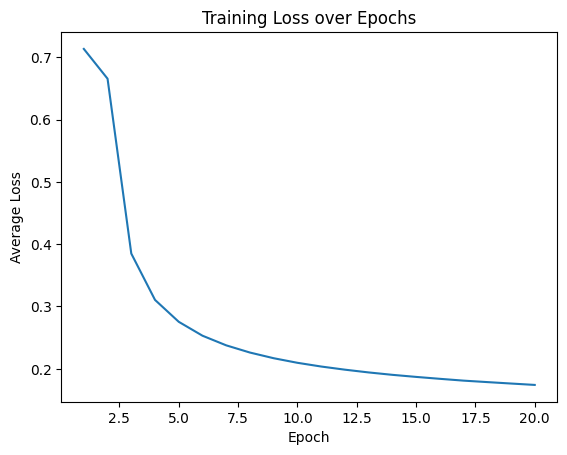

In [61]:
# define the first model

class PreTrainEmbeddingModelDotProduct(nn.Module):
    def __init__(self, n_customers, n_products, n_factors):
        super(preTrainEmbeddingModelDotProduct, self).__init__()
        self.cust_embedding = nn.Embedding(n_customers, n_factors)
        self.prod_embedding = nn.Embedding(n_products, n_factors)
        self.out = nn.Linear(1, 1)  # Since the dot product results in a single value, the output layer has 1 input feature
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        custs = self.cust_embedding(x[:,0])
        prods = self.prod_embedding(x[:,1])
        
        # Element-wise multiplication and sum to get the dot product
        dot_product = torch.sum(custs * prods, dim=1, keepdim=True)
        
        x = self.out(dot_product)
        x = self.sigmoid(x)
        return x



# Initialize the model, loss function, and optimizer
pre_training_model = preTrainEmbeddingModelDotProduct(n_customers, n_products, n_factors)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(pre_training_model.parameters(), lr=0.01)

# Data Loader (adjust batch_size as needed)
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(customer_indices_1, product_indices_1, true_shop)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)

# Initialize list to store loss values
epoch_loss = []

# Training loop (adjust epochs as needed)
epochs = 20
for epoch in range(epochs):
    batch_losses = []
    for i, (cust, prod, y) in enumerate(train_loader):
        y_pred = pre_training_model(torch.stack([cust, prod], dim=1).long())
        loss = criterion(y_pred.squeeze(), y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_loss.append(sum(batch_losses) / len(batch_losses))
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {epoch_loss[-1]}')

# Plotting the loss values
plt.plot(range(1, epochs+1), epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [62]:
# Save the state_dict of pretrained_model
torch.save(pre_training_model.state_dict(), "pre_training_model.pth")




In [144]:
pre_training_model.state_dict()

OrderedDict([('cust_embedding.weight',
              tensor([[-1.4854,  1.2226,  4.8530,  ...,  1.4748,  3.7887,  5.2714],
                      [ 1.2679,  3.8127, -1.4061,  ...,  5.9166, -0.2342, -1.3433],
                      [-0.3028,  1.0799, -1.8611,  ...,  1.1402, -1.5624,  2.0372],
                      ...,
                      [ 1.9291,  4.5179, -1.9089,  ...,  1.0411,  1.1544,  3.7832],
                      [ 0.2392,  2.4773,  1.1078,  ..., -0.3749,  3.1715, -1.3938],
                      [ 1.8640,  0.8783, -3.8883,  ...,  1.2578,  2.7978,  0.4993]])),
             ('prod_embedding.weight',
              tensor([[-3.1349,  4.2545,  0.4818,  ..., -0.1709,  2.0049, -1.5976],
                      [ 1.5478,  3.0138,  5.7202,  ...,  0.0633, -0.5137, -1.5810],
                      [ 1.9099,  1.5561,  8.1518,  ...,  0.4822,  1.4243, -2.8010],
                      ...,
                      [ 0.7344, -5.1232,  1.4025,  ..., -1.4965, -0.9666, -2.7912],
                      [ 1

## Train the second model using quantitites

In [ ]:
# Define the second model architecture
class SecondEmbeddingModel(nn.Module):
    def __init__(self, n_customers, n_products, n_factors):
        super(secondEmbeddingModel, self).__init__()
        self.cust_embedding = nn.Embedding(n_customers, n_factors)
        self.prod_embedding = nn.Embedding(n_products, n_factors)
        self.out = nn.Linear(1, 1)  # Since the dot product results in a single value, the output layer has 1 input feature
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        custs = self.cust_embedding(x[:,0])
        prods = self.prod_embedding(x[:,1])
        # Element-wise multiplication and sum to get the dot product
        dot_product = torch.sum(custs * prods, dim=1, keepdim=True)
        x = self.out(dot_product)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
second_model = secondEmbeddingModel(n_customers, n_products, n_factors)


In [ ]:
#second_model.load_state_dict(torch.load("pre_training_model.pth"), strict=False)

In [ ]:
second_model.load_state_dict(pre_training_model.state_dict(), strict=False)

In [ ]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(second_model.parameters(), lr=0.01)


train_data = TensorDataset(customer_indices_2, product_indices_2, quantities)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)

# Initialize list to store loss values
epoch_loss = []

# Training loop (adjust epochs as needed)
epochs = 20
for epoch in range(epochs):
    batch_losses = []
    for i, (cust, prod, y) in enumerate(train_loader):
        y_pred = second_model(torch.stack([cust, prod], dim=1).long())
        loss = criterion(y_pred.squeeze(), y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_loss.append(sum(batch_losses) / len(batch_losses))
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {epoch_loss[-1]}')

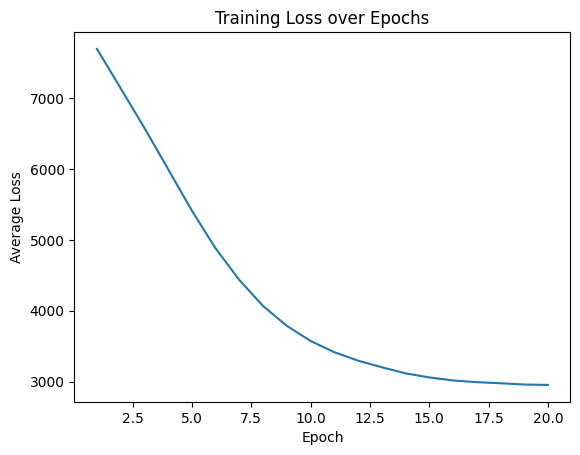

In [70]:
# Plotting the loss values
plt.plot(range(1, epochs+1), epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [83]:
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# Extract embeddings from the 1st model
customer_embeddings_1 = pre_training_model.cust_embedding.weight.detach().numpy()
product_embeddings_1 = pre_training_model.prod_embedding.weight.detach().numpy()

# Extract embeddings from the 2 model
customer_embeddings_2 = second_model.cust_embedding.weight.detach().numpy()
product_embeddings_2 = second_model.prod_embedding.weight.detach().numpy()

# Initialize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=20)
# Apply t-SNE to the embeddings
customer_tsne_1 = tsne.fit_transform(customer_embeddings_1)
product_tsne_1 = tsne.fit_transform(product_embeddings_1)
customer_tsne_2 = tsne.fit_transform(customer_embeddings_2)
product_tsne_2 = tsne.fit_transform(product_embeddings_2)



[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5127 samples in 0.001s...
[t-SNE] Computed neighbors for 5127 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5127
[t-SNE] Computed conditional probabilities for sample 2000 / 5127
[t-SNE] Computed conditional probabilities for sample 3000 / 5127
[t-SNE] Computed conditional probabilities for sample 4000 / 5127
[t-SNE] Computed conditional probabilities for sample 5000 / 5127
[t-SNE] Computed conditional probabilities for sample 5127 / 5127
[t-SNE] Mean sigma: 1.907452
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.202866
[t-SNE] KL divergence after 1000 iterations: 3.333187
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 4364 samples in 0.000s...
[t-SNE] Computed neighbors for 4364 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4364
[t-SNE] Computed conditional probabilities for sample 2000 / 4364
[t-SNE] Computed conditional 

In [97]:
customers_and_index = training_data[['Customer ID', 'CustomerIndex']].drop_duplicates().sort_values(['CustomerIndex']).reset_index(drop=True)

customer_tsne_1_Df = pd.DataFrame(customer_tsne_1).rename({0:'customer_tsne_1_0', 1:'customer_tsne_1_1'},axis=1)
customer_tsne_2_Df = pd.DataFrame(customer_tsne_2).rename({0:'customer_tsne_2_0', 1:'customer_tsne_2_1'},axis=1)


customers_and_index = customers_and_index.merge(customer_tsne_1_Df, how='inner',left_index=True, right_index=True)

In [98]:
customers_and_index = customers_and_index.merge(customer_tsne_2_Df, how='inner',left_index=True, right_index=True)

In [99]:
customers_and_index

,Customer ID,CustomerIndex,customer_tsne_1_0,customer_tsne_1_1,customer_tsne_2_0,customer_tsne_2_1
0,13085.0,0,9.982491,24.015726,-10.415578,-13.792974
1,13078.0,1,24.930658,13.620268,-3.488593,-3.329931
2,15362.0,2,-2.693555,-7.630621,14.375128,-5.850303
3,18102.0,3,40.369156,-13.200997,52.342884,-6.238366
4,12682.0,4,24.244984,27.391523,35.420490,-9.881428
...,...,...,...,...,...,...
5122,18013.0,5122,-7.848486,-1.237973,-17.042889,14.140457
5123,13681.0,5123,-14.282520,-35.677475,-13.308883,-17.678333
5124,13486.0,5124,-22.609020,-29.308577,-17.911364,27.307226
5125,12461.0,5125,-15.668703,2.867550,5.960192,-21.186104


In [100]:
data_customer_grouped = data_customer_grouped.merge(customers_and_index, how='inner', on='Customer ID')

In [101]:
data_customer_grouped

,Customer ID,avgDuration,countEvents,avgUniqueProds,avgSpending,CustomerIndex,customer_tsne_1_0,customer_tsne_1_1,customer_tsne_2_0,customer_tsne_2_1
0,12347.0,55.250000,4,28.400000,705.854004,4011,13.026643,18.300406,5.836199,30.010609
1,12348.0,63.333333,3,11.000000,427.350006,3576,-33.327667,18.051727,-26.360098,0.327507
2,12349.0,109.333333,3,26.750000,661.747498,351,19.925402,26.121719,41.110611,-15.628529
3,12350.0,NaN,0,17.000000,334.399994,4497,-8.349607,7.803634,-24.164377,-1.381880
4,12351.0,NaN,0,21.000000,300.929993,4324,-27.622879,22.887341,-20.342285,-20.831375
...,...,...,...,...,...,...,...,...,...,...
5122,18283.0,44.454545,11,43.750000,123.695831,1698,20.982666,5.267918,18.982731,11.479739
5123,18284.0,2.000000,1,14.500000,218.339996,3676,-10.987329,15.597024,-26.914217,-13.032566
5124,18285.0,NaN,0,12.000000,427.000000,1657,-13.673175,-29.569418,-11.315545,-0.971140
5125,18286.0,123.500000,2,23.333333,396.143311,928,23.025816,-1.048845,19.320217,-1.114851


In [102]:
data_customer_grouped['one-time-shoppers'] = pd.isna(data_customer_grouped['avgDuration'])

In [103]:
data_customer_grouped

,Customer ID,avgDuration,countEvents,avgUniqueProds,avgSpending,CustomerIndex,customer_tsne_1_0,customer_tsne_1_1,customer_tsne_2_0,customer_tsne_2_1,one-time-shoppers
0,12347.0,55.250000,4,28.400000,705.854004,4011,13.026643,18.300406,5.836199,30.010609,False
1,12348.0,63.333333,3,11.000000,427.350006,3576,-33.327667,18.051727,-26.360098,0.327507,False
2,12349.0,109.333333,3,26.750000,661.747498,351,19.925402,26.121719,41.110611,-15.628529,False
3,12350.0,NaN,0,17.000000,334.399994,4497,-8.349607,7.803634,-24.164377,-1.381880,True
4,12351.0,NaN,0,21.000000,300.929993,4324,-27.622879,22.887341,-20.342285,-20.831375,True
...,...,...,...,...,...,...,...,...,...,...,...
5122,18283.0,44.454545,11,43.750000,123.695831,1698,20.982666,5.267918,18.982731,11.479739,False
5123,18284.0,2.000000,1,14.500000,218.339996,3676,-10.987329,15.597024,-26.914217,-13.032566,False
5124,18285.0,NaN,0,12.000000,427.000000,1657,-13.673175,-29.569418,-11.315545,-0.971140,True
5125,18286.0,123.500000,2,23.333333,396.143311,928,23.025816,-1.048845,19.320217,-1.114851,False


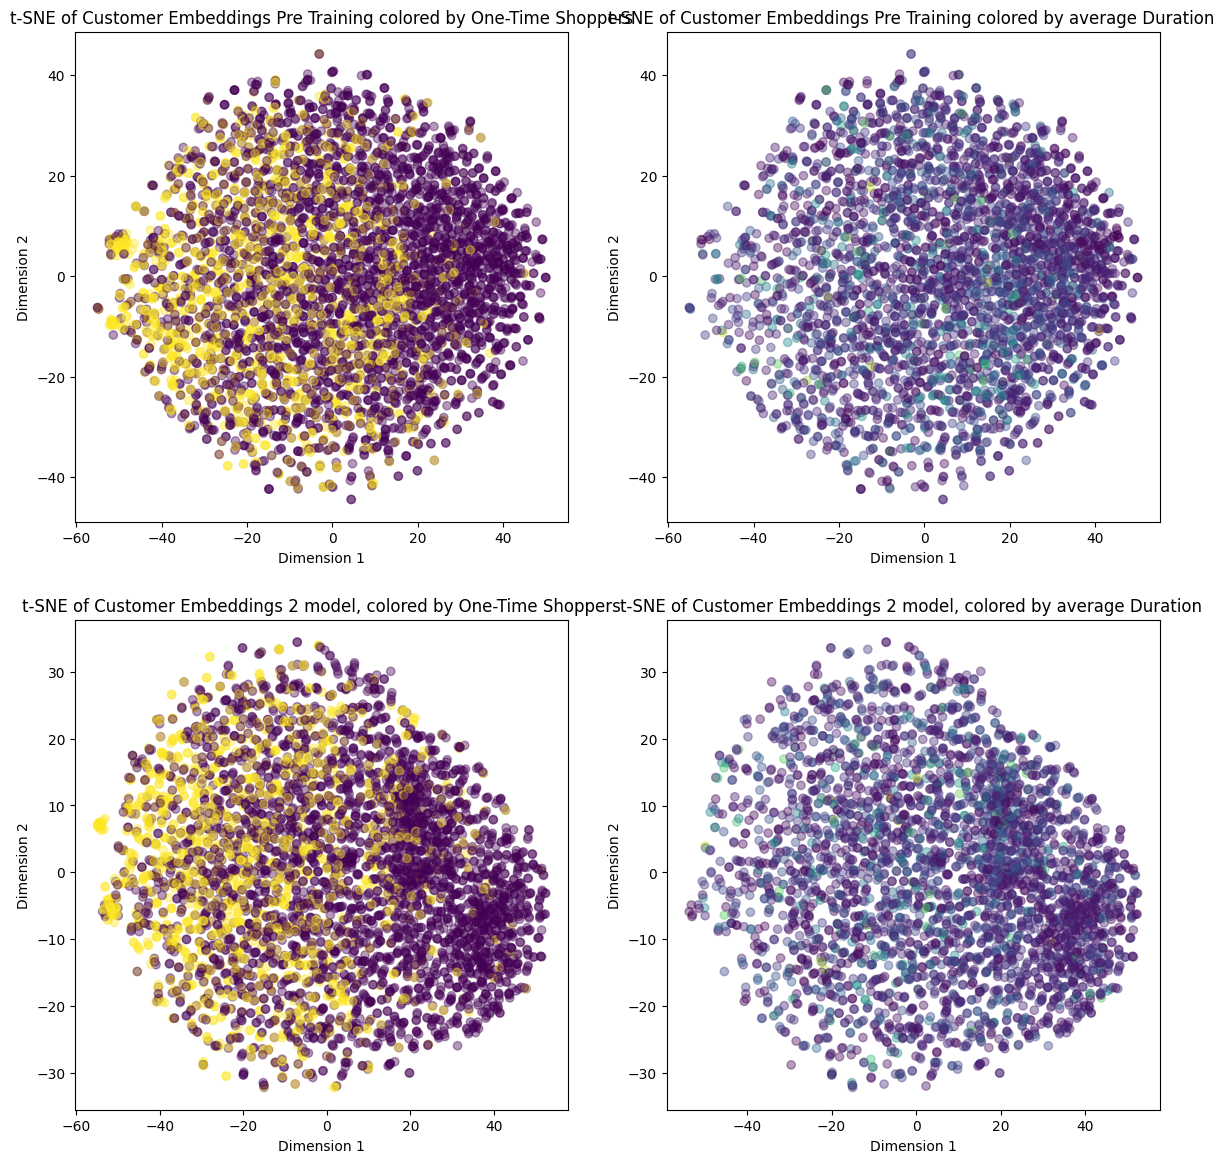

In [107]:
# Create plots for the t-SNE transformed embeddings
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Plot for Customer Embeddings Dataset 1
ax[0][0].scatter(data = data_customer_grouped, x='customer_tsne_1_0', y='customer_tsne_1_1', c='one-time-shoppers', label='Customer Embeddings', alpha=0.4)
ax[0][0].set_title('t-SNE of Customer Embeddings Pre Training colored by One-Time Shoppers')
ax[0][0].set_xlabel('Dimension 1')
ax[0][0].set_ylabel('Dimension 2')

ax[0][1].scatter(data = data_customer_grouped[data_customer_grouped['one-time-shoppers']==False], x='customer_tsne_1_0', y='customer_tsne_1_1', c='avgDuration', label='Customer Embeddings', alpha=0.4)
ax[0][1].set_title('t-SNE of Customer Embeddings Pre Training colored by average Duration ')
ax[0][1].set_xlabel('Dimension 1')
ax[0][1].set_ylabel('Dimension 2')

# Plot for Customer Embeddings Dataset 2
ax[1][0].scatter(data = data_customer_grouped, x='customer_tsne_2_0', y='customer_tsne_2_1', c='one-time-shoppers', label='Customer Embeddings', alpha=0.4)
ax[1][0].set_title('t-SNE of Customer Embeddings 2 model, colored by One-Time Shoppers')
ax[1][0].set_xlabel('Dimension 1')
ax[1][0].set_ylabel('Dimension 2')

ax[1][1].scatter(data = data_customer_grouped[data_customer_grouped['one-time-shoppers']==False], x='customer_tsne_2_0', y='customer_tsne_2_1', c='avgDuration', label='Customer Embeddings', alpha=0.4)
ax[1][1].set_title('t-SNE of Customer Embeddings 2 model, colored by average Duration ')
ax[1][1].set_xlabel('Dimension 1')
ax[1][1].set_ylabel('Dimension 2')


plt.show()

Based on the these t-SNE plots it clearly seems that our embedding of customers (based solely on which products they buy and the quantity they buy them in) is able encapsulate important information about the customers and can for instance disriminate on which customers are likely to be one-time-shoppers and and not. 

We can now use the embeddings model we can use this a starting point for sampling customers and their likely shopping baskets.

## Save to disk to for use in the model

For most of the later modeling using embeddings we use these embeddings directly, so we save them to disc

In [ ]:
customers_and_index_2 = pd.concat([customers_and_index, pd.DataFrame(customer_embeddings_2)], axis=1)

customers_and_index_2.to_csv('/home/hcekne/data/online_retail_ii/customer_embeddings_full.csv')

product_and_index = training_data[['StockCode', 'ProductIndex']].drop_duplicates().sort_values(['ProductIndex']).reset_index(drop=True)

product_and_index_2 = pd.concat([product_and_index, pd.DataFrame(product_embeddings_2)], axis=1)

product_and_index_2.to_csv('/home/hcekne/data/online_retail_ii/product_embeddings_full.csv')